In [1]:
#tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
#matplotlib inline

ImportError: Traceback (most recent call last):
  File "/home/nitin/.local/lib/python3.7/site-packages/tensorflow/python/__init__.py", line 61, in <module>
    from tensorflow.python import pywrap_tensorflow
  File "/home/nitin/.local/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow.py", line 28, in <module>
    _pywrap_tensorflow = swig_import_helper()
  File "/home/nitin/.local/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow', fp, pathname, description)
  File "/usr/lib/python3.7/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/usr/lib/python3.7/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: /home/nitin/.local/lib/python3.7/site-packages/tensorflow/python/_pywrap_tensorflow.so: invalid ELF header


Failed to load the native TensorFlow runtime.

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/get_started/os_setup.md#import_error

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [41]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=2000')
print(res)
hist = pd.DataFrame(json.loads(res.content)['Data'])
'''
predictive = {"time":[]}
for i in range(100):
    predictive["time"].append(hist["time"][2000] + (i+1)*86400)
    
predictive = pd.DataFrame(predictive)
print(predictive)
hist = pd.concat([hist,predictive],ignore_index = True)
print(hist)
'''
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'


<Response [200]>


In [42]:
print(hist)


                high       low      open  volumefrom    volumeto     close  \
time                                                                         
2016-12-04   1017.00   1007.01   1017.00      158.48   161201.49   1017.00   
2016-12-05   1017.00    994.00   1017.00      241.40   243283.25   1008.82   
2016-12-06   1010.99    998.16   1008.82      227.02   229523.69   1010.00   
2016-12-07   1017.63   1000.01   1010.00      268.43   272126.46   1010.74   
2016-12-08   1018.00   1003.01   1010.74      307.08   311941.36   1017.97   
...              ...       ...       ...         ...         ...       ...   
2022-05-23  39138.84  36918.26  38856.05       57.71  2215947.33  37161.03   
2022-05-24  38171.58  36642.62  37161.03       83.64  3110028.03  37995.98   
2022-05-25  38663.05  37762.72  37995.98       70.78  2694899.44  37858.57   
2022-05-26  38279.17  35953.99  37858.57      131.41  4896654.47  37326.95   
2022-05-27  37464.46  35991.39  37326.95       57.49  2111850.91

In [43]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [44]:
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2016-12-04,1017.00,1007.01,1017.00,158.48,161201.49,1017.00
2016-12-05,1017.00,994.00,1017.00,241.40,243283.25,1008.82
2016-12-06,1010.99,998.16,1008.82,227.02,229523.69,1010.00
2016-12-07,1017.63,1000.01,1010.00,268.43,272126.46,1010.74
2016-12-08,1018.00,1003.01,1010.74,307.08,311941.36,1017.97
...,...,...,...,...,...,...
2022-05-23,39138.84,36918.26,38856.05,57.71,2215947.33,37161.03
2022-05-24,38171.58,36642.62,37161.03,83.64,3110028.03,37995.98
2022-05-25,38663.05,37762.72,37995.98,70.78,2694899.44,37858.57


In [45]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [46]:
train, test = train_test_split(hist, test_size=0.1)

In [47]:
train

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2016-12-04,1017.00,1007.01,1017.00,158.48,1.612015e+05,1017.00
2016-12-05,1017.00,994.00,1017.00,241.40,2.432832e+05,1008.82
2016-12-06,1010.99,998.16,1008.82,227.02,2.295237e+05,1010.00
2016-12-07,1017.63,1000.01,1010.00,268.43,2.721265e+05,1010.74
2016-12-08,1018.00,1003.01,1010.74,307.08,3.119414e+05,1017.97
...,...,...,...,...,...,...
2021-11-04,78291.48,75455.43,78051.33,3009.87,2.313692e+08,76698.03
2021-11-05,78243.17,75412.51,76698.03,4222.31,3.232532e+08,75735.38
2021-11-06,76899.22,74672.88,75735.38,3641.76,2.770490e+08,76342.33


In [48]:
test

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-11-09,85551.96,82281.77,83762.71,2574.31,2.161161e+08,82964.70
2021-11-10,85805.64,78425.57,82964.70,3325.90,2.760509e+08,81294.31
2021-11-11,82541.00,79889.19,81294.31,2504.95,2.038858e+08,81812.05
2021-11-12,82662.73,77992.17,81812.05,3446.16,2.783208e+08,80732.43
2021-11-13,81712.25,79305.22,80732.43,4005.33,3.217836e+08,80557.80
...,...,...,...,...,...,...
2022-05-23,39138.84,36918.26,38856.05,57.71,2.215947e+06,37161.03
2022-05-24,38171.58,36642.62,37161.03,83.64,3.110028e+06,37995.98
2022-05-25,38663.05,37762.72,37995.98,70.78,2.694899e+06,37858.57


In [49]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

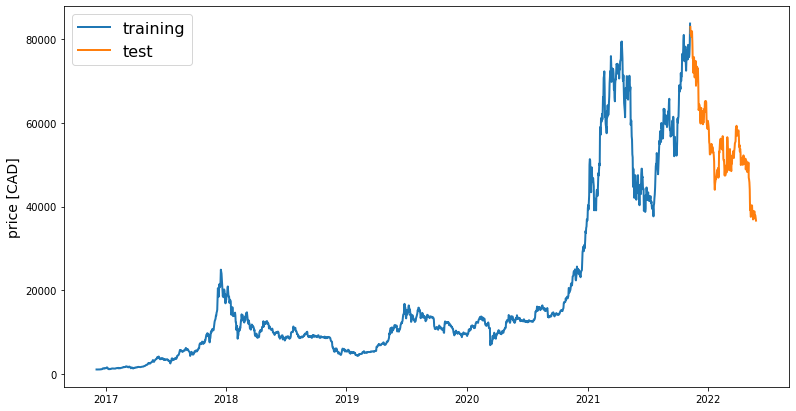

In [50]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [51]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [52]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [53]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.1):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [54]:
def build_lstm_model(input_data, output_size, neurons=300, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [55]:
np.random.seed(42)
window_len = 5
test_size = 0.1
zero_base = True
lstm_neurons = 300
epochs = 50
batch_size = 36
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [56]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [57]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
print(type(model))
print(type(history))
print(type(history.history))

Epoch 1/50
50/50 [==============================] - 2s 14ms/step - loss: 0.0112 - val_loss: 0.0020
Epoch 2/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 3/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 4/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 5/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 6/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 7/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 8/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 9/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 10/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 11/50
50/50 

In [58]:
print(history)

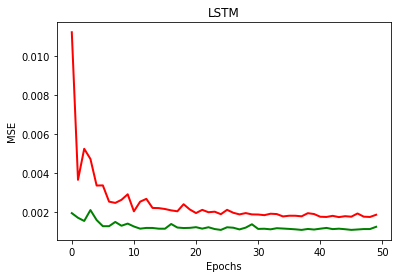

In [59]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [60]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)
print(type(targets))
print(type(preds))
mean_absolute_error(preds, y_test)

7/7 [==============================] - 0s 3ms/step
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


0.026203666713667927

In [61]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.001265647520892475

In [62]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7286110040016511

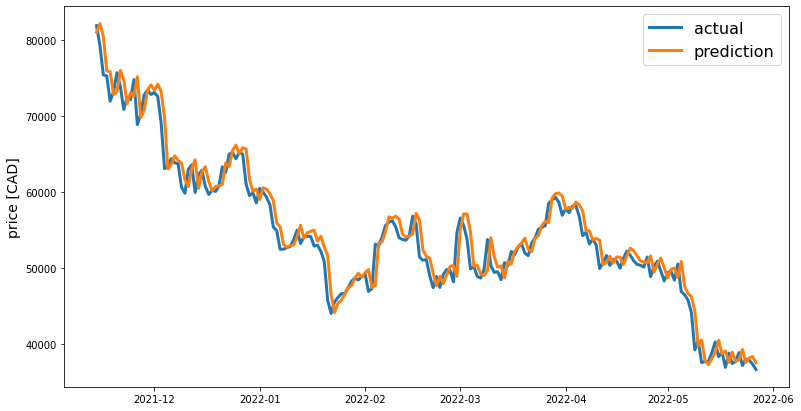

In [63]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [64]:
print("hello")

hello
